In [45]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch 
import matplotlib.pyplot as plt

In [46]:
doge_df = pd.read_csv('dataset/doge.csv')

In [47]:
doge_df.head()

,Date,Open,High,Low,Close
0,2019-01-01,0.002319,0.002382,0.002246,0.002365
1,2019-01-02,0.002378,0.002407,0.002315,0.002354
2,2019-01-03,0.002358,0.002441,0.002268,0.002294
3,2019-01-04,0.002297,0.002331,0.002174,0.002270
4,2019-01-05,0.002292,0.002316,0.002212,0.002258


# EDA

In [48]:
doge_df.shape

(1217, 5)

In [49]:
doge_df.index = doge_df['Date']

In [50]:
doge_df.index = pd.to_datetime(doge_df.index)

In [51]:
doge_df.drop(columns=['Date','Open','High','Low'],inplace=True)

In [52]:
idx = int(len(doge_df)*0.9)
train_df = doge_df[:idx]
test_df = doge_df[idx:]

In [53]:
train_values = train_df['Close'].values.reshape(-1,1)
test_values = test_df['Close'].values.reshape(-1,1)

# normalizing data

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled_training = scaler.fit_transform(train_values)
scaled_testing = scaler.fit_transform(test_values)

In [55]:
n_past = 40
n_future = 5
x_train = []
y_train = []
x_test = []
y_test = []

# train-test split

In [56]:
for i in range(n_past,len(train_values)-n_future + 1):
    x_train.append(scaled_training[i-n_past:i,0:train_values.shape[1]])
    y_train.append(scaled_training[i:i+n_future,0:train_values.shape[1]])

In [57]:
for i in range(n_past,len(test_values)-n_future +1):
    x_test.append(scaled_testing[i-n_past:i,0:test_values.shape[1]])
    y_test.append(scaled_testing[i:i+n_future,0:test_values.shape[1]])

In [58]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [59]:
print('x_train shape == {}'.format(x_train.shape))
print('y_train shape == {}'.format(y_train.shape))

x_train shape == (1051, 40, 1)
y_train shape == (1051, 5, 1)


In [60]:
print('x_test shape == {}'.format(x_test.shape))
print('y_test shape == {}'.format(y_test.shape))

x_test shape == (78, 40, 1)
y_test shape == (78, 5, 1)


the shape of data is(total_dataset in sequence, sequence length,input size) 

for each sequence length , we only stride one new data each new sequence.
for example sequence-1 = [0.33,0.35,0.37]
then the next sequence is = [0.35,0.37,0.40]

# training model

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
x_tensor = torch.from_numpy(x_train)
y_tensor = torch.from_numpy(y_train) 

In [63]:
xtest_tensor = torch.from_numpy(x_test)
ytest_tensor = torch.from_numpy(y_test)

In [64]:
import model_seq2seq

In [65]:
model = model_seq2seq.lstm_seq2seq(input_size = x_tensor.size(2), hidden_size = 8, num_layers=1)


In [66]:
loss = model.train(x_tensor.float(), y_tensor.float(), epochs= 100, target_len= y_tensor.size(1), batch_size= 5, training_prediction='teacher_forcing')

100%|██████████| 100/100 [06:36<00:00,  3.97s/it, loss=0.010]


In [67]:
result = model.predict(xtest_tensor[-1].float(),5)

In [68]:
result

array([[0.42901963],
       [0.3120301 ],
       [0.3185643 ],
       [0.31038696],
       [0.3111733 ]], dtype=float32)

# inverse result

In [69]:
result = scaler.inverse_transform(result)

the reason why i add one more data-1 ahead before the predicting data is because i want the predicting data line to be connected with the test_data line

In [77]:
predicted_df = test_df.tail(6)

In [79]:
predicted_df.values[1:]

array([[0.13979452],
       [0.13757421],
       [0.13495766],
       [0.12741741],
       [0.12744624]])

In [80]:
predicted_df = predicted_df.replace(predicted_df[1:].values,result)

In [81]:
predicted_df

,Close
Date,
2022-04-26,0.137548
2022-04-27,0.143039
2022-04-28,0.134479
2022-04-29,0.134957
2022-04-30,0.134358
2022-05-01,0.134416


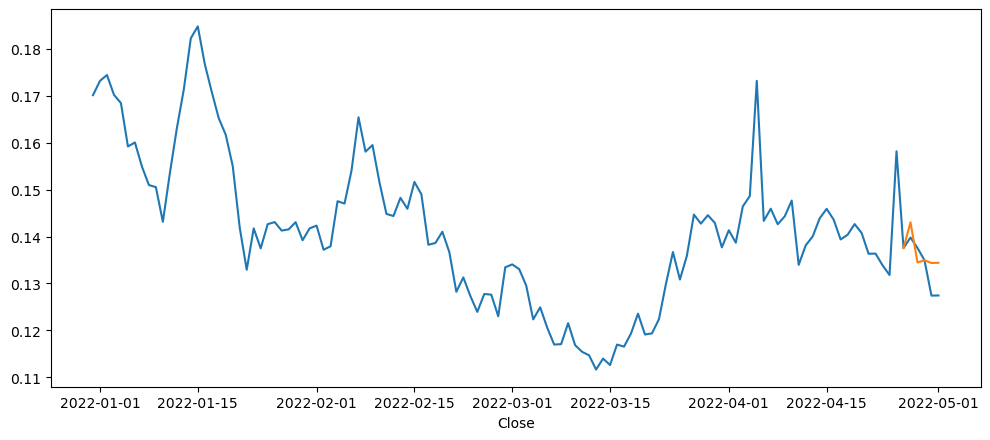

In [82]:
plt.figure(figsize=(12,5),dpi=100)
plt.plot(test_df)
plt.plot(predicted_df)
plt.xlabel(str('Close'))
plt.show()